In [296]:
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from shapely.geometry import LineString
from shapely.ops import linemerge
from utils import EarthquakeCatalog
from sklearn.neighbors import BallTree
from scipy.stats import bootstrap
from typing import Callable, Optional, List

font = {'size'   : 8}

matplotlib.rc('font', **font)

Cross section along a spreading ridge. 

Steps:
* Get shapefile for spreading ridge
* Convert to better reference system (?)
* Upsample at desired point spacing
* get corresponding earthquake catalog
* get k-nearest earthquakes at each point along spreading ridge
* calculate statistics:
  * b-value (b+)
  * a-value
* get spatially averaged strain along the same section
* correlate statistics to strain rate

Subsequent analysis:
* remove trends associated to spreading rate and faulting style 
* clustrered vs. declustered
* record major geological features along the spreading ridge (e.g. iceland, major earthquakes, etc)

Note that an analysis could closely follow the workflow in:

*A unified perspective of seismicity and fault coupling along the San Andreas Fault*

https://www.science.org/doi/full/10.1126/sciadv.abk1167?fbclid=IwAR2HdRzrYRcHJaV3LrciFyn0m-9RpNZ20oOmbagbXI176iIFLSaHxj3LiUk&intcmp=trendmd-adv&adobe_mc=MCMID%3D22100252661862915997832685880766884763%7CMCORGID%3D242B6472541199F70A4C98A6%2540AdobeOrg%7CTS%3D1652659200

In a quick literature review it seems like some of this analysis has already been done:

*Ice melting and earthquake suppression in Greenland*

https://www.sciencedirect.com/science/article/pii/S1873965214000681#bib3

Relavant litterature and resouces:

Here is a relatively detailed record of the seismic network in the polar region:

https://www.ngdc.noaa.gov/mgg/avetisov/CHAP1.htm

A catalog more or less complete to M4.5 in 1965!

Lynn R. Sykes; The seismicity of the Arctic. Bulletin of the Seismological Society of America 1965;; 55 (2): 501–518. doi: https://doi.org/10.1785/BSSA0550020501




## Shapefile for the north atlantic spreading ridge

In [116]:
plate_boundaries = gpd.read_file("PB2002_boundaries.shp")

In [153]:
north_antlantic_plate_boundary = plate_boundaries.loc[(plate_boundaries.Name=='NA-EU') | (plate_boundaries.Name=='EU-NA')]
north_antlantic_plate_boundary

,LAYER,Name,Source,PlateA,PlateB,Type,geometry
62,plate boundary,NA-EU,"by Peter Bird, 1999",NA,EU,None,"LINESTRING (125.67900 78.13260, 126.45700 77.6..."
63,plate boundary,NA-EU,Mueller et al. [1987],NA,EU,None,"LINESTRING (-15.71560 69.54990, -15.42450 69.8..."
64,plate boundary,NA-EU,Mueller et al. [1987],NA,EU,None,"LINESTRING (-29.76980 39.39960, -29.60890 39.9..."
156,plate boundary,EU-NA,"by Peter Bird, November 2001",EU,NA,None,"LINESTRING (-15.71560 69.54990, -16.03350 69.2..."


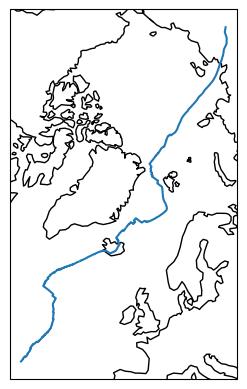

In [265]:
# crs are always a bit confusing: here we set axis and boundary geometry to
# the same north polar stereographic projection.
crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init
na_pb = north_antlantic_plate_boundary.geometry.to_crs(crs_proj4)

fig, ax = plt.subplots(subplot_kw=dict(projection=crs))
na_pb.plot(ax=ax)
ax.coastlines();

## Entering Coordinate reference system hell

In [119]:

def densify_geometry(line_geometry, step, crs_in=None, crs_out=None):
    
    # crs: epsg code of a coordinate reference system you want your line to be georeferenced with
    # step: add a vertice every step in whatever unit your coordinate reference system use.

    length_m=line_geometry.length # get the length

    xy=[] # to store new tuples of coordinates

    for distance_along_old_line in np.arange(0,int(length_m),step): 

        point = line_geometry.interpolate(distance_along_old_line) # interpolate a point every step along the old line
        xp,yp = point.x, point.y # extract the coordinates

        xy.append((xp,yp)) # and store them in xy list

    new_line=LineString(xy) # Here, we finally create a new line with densified points.
    
    if crs_in != None:  #  If you want to georeference your new geometry, uses crs to do the job.
        new_line_geo=gpd.geoseries.GeoSeries(new_line,crs=crs)
    
    if crs_out != None:
        new_line_geo=new_line_geo.to_crs(crs_out)
        return new_line_geo

    else:
        return new_line

def merge_and_densify_geodataframe(gdf, step, crs_in=None, crs_out=None):
    
    # crs: epsg code of a coordinate reference system you want your line to be georeferenced with
    # step: add a vertice every step in whatever unit your coordinate reference system use.

    gdf_densified = gdf.copy()
    gdf_densified = gdf_densified.to_crs(crs_in) 
    
    gdf_densified.geometry = gdf_densified.geometry.apply(lambda x: densify_geometry(x, step, crs_in, crs_out))
    
    return gdf_densified

In [120]:
north_antlantic_plate_boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [168]:
crs_in = crs_proj4
crs_out = "EPSG:4326"

boundary_in_meters = north_antlantic_plate_boundary.to_crs(crs_in)
merged_boundary_in_meters = linemerge(boundary_in_meters.geometry.values)
interp_merged_boundary = densify_geometry(
    merged_boundary_in_meters, 100000,
    crs_in = crs_in, crs_out = crs_out,
).geometry.values[0]

In [267]:
bounds = north_antlantic_plate_boundary.total_bounds
print(
    'Total bounds of the selected plate boundary:\n{}'.format(
        bounds,
    )
)

Total bounds of the selected plate boundary:
[-35.4878  39.3996 144.932   86.8049]


## Get earthquakes for the corresponding region

In [259]:
MAGNITUDE_OF_COMPLETENESS = 4.5

reload_catalog = False
filename = "north_atlantic_catalog.csv"
if reload_catalog is True:
    bounds = north_antlantic_plate_boundary.total_bounds
    catalog = EarthquakeCatalog.get_and_save_catalog(
        filename = filename,
        starttime = "1980-01-01",
        endtime = "2022-01-01",
        latitude_range = bounds[1:4:2],
        longitude_range = bounds[0:3:2],
        minimum_magnitude = MAGNITUDE_OF_COMPLETENESS,
    )
else:
    catalog = pd.read_csv(filename)

In [261]:
catalog = EarthquakeCatalog._add_time_column(catalog, "time")

In [172]:
catalog

,EVENT_ID,time,lat,lon,dep,mag
0,11521196,2021-12-30 03:59:17.645999872,39.7509,141.9686,64390.0,4.7
1,11511490,2021-12-29 13:58:30.792999936,85.1788,93.2356,10000.0,5.0
2,11515221,2021-12-28 15:19:25.701999872,50.5026,143.7494,10000.0,4.5
3,11510848,2021-12-26 19:40:05.104999936,41.9435,142.3073,66010.0,4.6
4,11515571,2021-12-26 10:50:37.086999808,53.6882,-34.5764,10000.0,4.7
...,...,...,...,...,...,...
12187,2882316,1980-01-07 23:44:25.209999936,40.2194,125.0208,3000.0,5.0
12188,2881986,1980-01-06 20:05:37.799999936,71.0132,-6.5045,10000.0,4.5
12189,2881615,1980-01-05 14:32:26.810000000,45.0561,7.3912,10600.0,4.8
12190,2881380,1980-01-04 16:42:08.670000064,42.6632,144.4575,90000.0,5.1


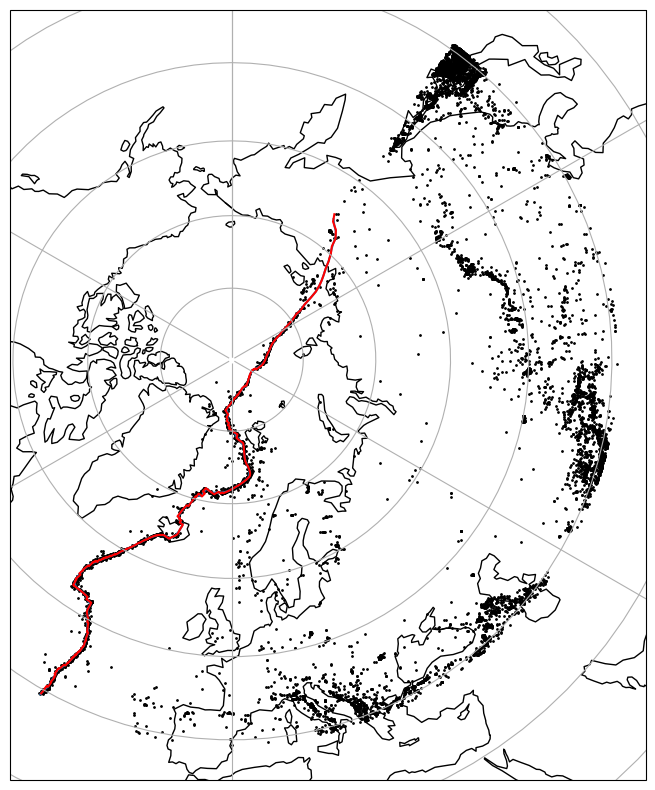

In [175]:
crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init

fig, ax = plt.subplots(subplot_kw=dict(projection=crs), figsize=(10, 10))
ax.plot(*interp_merged_boundary.xy, transform=ccrs.PlateCarree())
na_pb.plot(ax=ax, color="red")
ax.coastlines()
ax.gridlines()
ax.scatter(x=catalog.lon.to_numpy(), y=catalog.lat.to_numpy(), transform=ccrs.PlateCarree(), color='k', s=1);

In [294]:
type(boundary)

shapely.geometry.linestring.LineString

## distance search

In [320]:
EARTH_RADIUS = 6371 # km 
def radius_search(points,queries,radius)->list[list]:
    """Searches for points within a radius of a query lat lon point and returns a list of corresponding indices."""
    tree = BallTree(np.deg2rad(points), metric='haversine')
    return tree.query_radius(np.deg2rad(queries),r=radius/EARTH_RADIUS,return_distance=False)

def k_nearest_search(points,queries,k):
    """Searches for k nearest points to a query lat lon point and returns a list of corresponding indices."""
    tree = BallTree(np.deg2rad(points), metric='haversine')
    return tree.query(np.deg2rad(queries),k=k)[1] 

def get_geometry_neighbors(
    catalog: pd.DataFrame,
    boundary: LineString,
    fun: Callable = radius_search,
    kwarg: dict = {"radius":100},
    return_unique: bool = False,
    ):
    """Returns a list of indices of earthquakes that are neighboring the the specified linestring geometry."""

    queries = np.array([boundary.xy[1], boundary.xy[0]]).T
    points = np.array([catalog.lat.to_numpy(),catalog.lon.to_numpy()]).T

    indices = fun(points,queries,**kwarg)

    if return_unique:
        indices = np.unique(np.concatenate(indices))
    
    return indices

## The plate boundary catalog

We can generate a subcatalog that follows the plate boundary with.

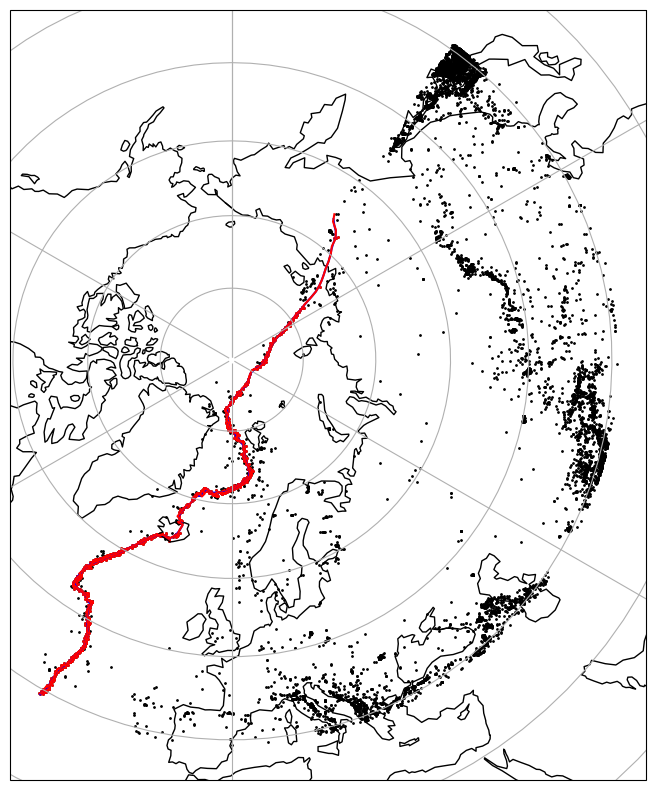

In [307]:
plate_boundary_catalog = catalog.copy()
unique_indices = get_geometry_neighbors(catalog, interp_merged_boundary, fun=radius_search, kwarg={"radius":50}, return_unique=True)
plate_boundary_catalog = plate_boundary_catalog.iloc[unique_indices]

crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init

fig, ax = plt.subplots(subplot_kw=dict(projection=crs), figsize=(10, 10))
ax.plot(*interp_merged_boundary.xy, transform=ccrs.PlateCarree())
na_pb.plot(ax=ax, color="red")
ax.coastlines()
ax.gridlines()
ax.scatter(x=catalog.lon.to_numpy(), y=catalog.lat.to_numpy(), transform=ccrs.PlateCarree(), color='k', s=1);
ax.scatter(x=plate_boundary_catalog.lon.to_numpy(), y=plate_boundary_catalog.lat.to_numpy(), transform=ccrs.PlateCarree(), color='r', s=1);

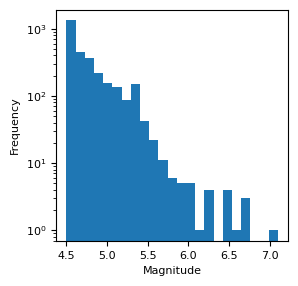

In [324]:
plate_boundary_catalog.plot(kind="hist", y="mag", bins=len(plate_boundary_catalog.mag.unique()),legend=False,figsize=(3,3));
plt.yscale("log")
plt.xlabel("Magnitude");

## Statistics

In [176]:
def get_bvalue(M,Mc,inc=0.0,jitter=False):
    """Returns the b-value for a given set of magnitudes M."""
    if jitter:
        M = M + np.random.normal(0,inc,M.shape)
    b = np.log10(np.exp(1))/(np.mean(M)-Mc+inc*0.5)
    return b

def get_bpositive(M,Mc):
    """Returns the b-value for a given set of magnitudes M using b positive. 
    
    Note that this assumes that magntidudes are sorted in increasing temporal order."""
    b = get_bvalue(np.diff(M),Mc)
    return b

def get_clustered_fraction(t):
    """Returns the fraction of clustered events for a given time series of events."""
    dt = np.diff(t)
    tau = dt/np.mean(dt)
    return 1 / np.std(tau)  

## Along strike variations

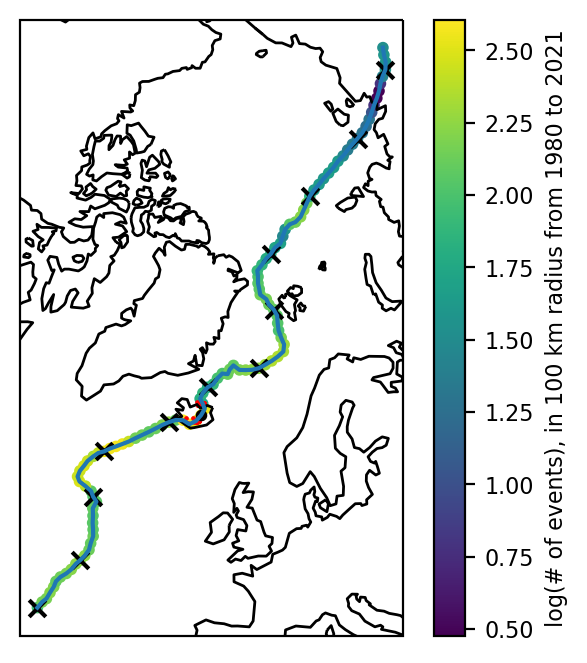

In [310]:
RADIUS = 200 # km
indices = get_geometry_neighbors(catalog, interp_merged_boundary, fun=radius_search, kwarg={"radius":RADIUS})
rate = [len(i) for i in indices]

crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init

fig, ax = plt.subplots(subplot_kw=dict(projection=crs),figsize=(4,4),dpi=200)
ax.plot(*interp_merged_boundary.xy, transform=ccrs.PlateCarree())
bdr = ax.scatter(queries[:,1],queries[:,0],c=np.log10(rate), s = 10, transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(bdr,label=f'log(# of events), in {radius} km radius from {catalog.time.min().year} to {catalog.time.max().year}');
i = 45
ax.scatter(points[indices[i],1], points[indices[i],0], s=0.5,c='r', transform=ccrs.PlateCarree())
ax.scatter(queries[i,1],queries[i,0],s=10,c='k', transform=ccrs.PlateCarree())
ax.scatter(queries[::10,1],queries[::10,0],marker='x',c='k', transform=ccrs.PlateCarree());

**Figure**: Along strike variatiosn in the rate of seismicity along the Mid Atlantic Ridge. Note that the colorbar is log-scaled. In red is an example of the earthquakes within the specified search radius. Crosses are distributed at every 10th equaly spaced point along the boundary.

## Variations in time and space:

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_13434/2331007549.py:60: UserWarning: The following kwargs were not used by contour: 'aspect'
  cf = ax.contourf(


Text(0.5, 0, 'Rate')

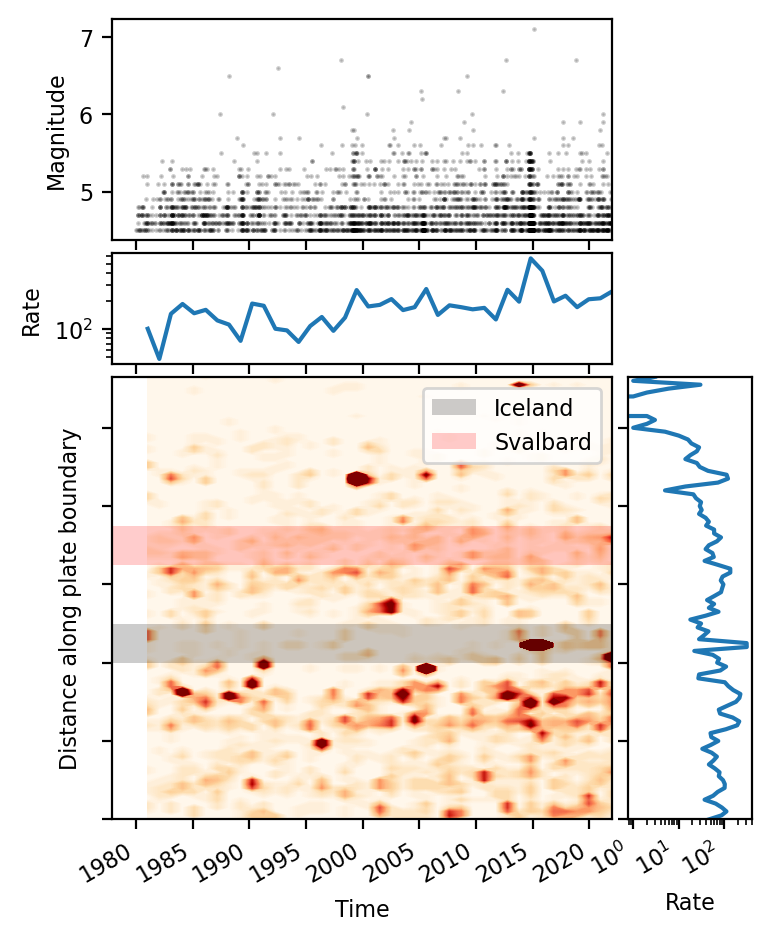

In [327]:
NUMBER_OF_PERIODS = 42 # number of periods to split the catalog into
WINDOW_SIZE = 100 # km

rate_grid = []
b_time = []
all_indices = []

catalog.time.sort_values(ignore_index=True)

date_range = pd.date_range(
    catalog.time.min(),
    catalog.time.max(),
    periods=NUMBER_OF_PERIODS
)

for t1,t2 in zip(date_range[:-1],date_range[1:]):
    sub_catalog = catalog[(catalog.time < t2) &  (catalog.time > t1)]
    indices = get_geometry_neighbors(
        sub_catalog, 
        interp_merged_boundary, 
        fun=radius_search, 
        kwarg={"radius":WINDOW_SIZE}
    )
    all_indices.append(indices)
    rate_grid.append([len(i) for i in indices])

rate_grid = np.array(rate_grid).T

#b_time = np.array(b_time)

points = np.array([catalog.lat.to_numpy(),catalog.lon.to_numpy()]).T
indices = radius_search(points,queries,RADIUS)
#b_space= np.array([get_bvalue(catalog.mag.to_numpy()[i],MAGNITUDE_OF_COMPLETENESS) for i in indices])


fig = plt.figure(figsize=(4, 5), dpi=200)
gs = fig.add_gridspec(3, 2,  width_ratios=(4, 1), height_ratios=(2, 1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[2, 0])
ax_seis = fig.add_subplot(gs[0, 0], sharex=ax)
ax_x = fig.add_subplot(gs[1, 0], sharex=ax)
ax_y = fig.add_subplot(gs[2, 1], sharey=ax)

# plot the earthquake catalog
ax_seis.scatter(plate_boundary_catalog.time.to_numpy(),plate_boundary_catalog.mag.to_numpy(),s=0.5,c='k',alpha=0.2)
ax_seis.set_ylabel('Magnitude')

# plot the rate_grid of events over time
ax_x.plot(date_range[1:], rate_grid.sum(axis=0))
ax_x.set_yscale('log')
ax_x.set_ylabel('Rate')
# ax_x_b = ax_x.twinx()
# ax_x_b.plot(date_range[1:], b_time, c='r')

# plot the rate_grid of events over time and space
max_level = 0.1*rate_grid.max()
levels = np.linspace(rate_grid.min(),max_level,100)
cf = ax.contourf(
    date_range[1:],
    np.arange(len(rate_grid))*100,
    rate_grid,
    levels=levels, 
    aspect='auto',
    cmap='OrRd',
    vmax=max_level, 
    extend="max",
    extent=[0,rate_grid.shape[1],0,rate_grid.shape[0]]
)

ax.axhspan(4000,5000,facecolor='k',alpha=0.2,label='Iceland')
ax.axhspan(6500,7500,facecolor='r',alpha=0.2,label='Svalbard')
ax.legend()

ax.set_xlabel("Time")
ax.set_ylabel("Distance along plate boundary")
plt.gcf().autofmt_xdate()

# plot the rate of events over space
ax_y.plot(rate_grid.sum(axis=1), np.arange(len(rate_grid))*100)
ax_y.set_yticklabels([])
ax_y.set_xscale('log')
ax_y.set_xlabel('Rate')
# ax_y_b = ax_y.twiny()
# ax_y_b.plot(b_space, np.arange(len(rate))*100, c='r')